# Set up

In [ ]:
library(glue)
library(dplyr)
library(parallel)

ncores <- as.numeric(Sys.getenv('SLURM_CPUS_PER_TASK'))
if (is.null(ncores)){n.cores <- parallel::detectCores()}
ncores

library(ggplot2)
library(ggrepel)
library(ggpubr)
library(ggh4x)
library(viridis)


# Helper function to set plot dimensions for subsequent plots
fig <- function(width, heigth){
 options(repr.plot.width = width, repr.plot.height = heigth)
 }


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] 24

Loading required package: viridisLite



# Factors, palettes, names...

## Datasets to use

In [2]:
datasets <- c('Gliogenesis', 'NeuralPCW20', 'NeuralPCW21', 'NeuralPCW24')
dataset.shapes <- c(16,17,15,18) %>% setNames(nm = datasets)

## Cell types

In [3]:
celltype.order <- c(
    
    'RGC', 'vRG', 'vtRG', 'oRG', 'RG E', 'RG L',
    'vRG E', 'vRG L', 'tRG', 'oRG E', 'oRG L', 
    
    'Neural', 'GluN',
    'nIPC', 'Neu E',
    
    'GluN3', 'GluN1', 'GluN2', 'GluN7',
    'GluN5', 'GluN4',
    'GluN6', 'GluN8',
    
    'Glial', 'Diff Glia',
    'mGPC', 'Astro', 'OPC')

celltype.labels <- celltype.order

celltype.colors <- setNames(
    c(
        '#bec1d4','#7d87b9','#023fa5','#d6bcc0','#bb7784','#8e063b','#b5bbe3',
        '#8595e1','#4a6fe3','#e6afb9','#e07b91','#d33f6a','#11c638','#c6dec7',
        '#8dd593','#ead3c6','#f0b98d','#ef9708','#0fcfc0','#9cded6','#d5eae7',
        '#f3e1eb','#f6c4e1','#f79cd4','#7f7f7f','#c7c7c7','#1CE6FF','#336600'
    )[1:length(celltype.order)],
    celltype.order)


## Diseases

In [ ]:
# Define path for disease information file
disease_info_file <- '/users/genomics/xoel/Review_CD/1.exp_linnarson/DiseaseInfoForJay.csv'

# Read disease info using the variable
disease.info <- read.csv(disease_info_file, row.names = 1)
disease.info

,Disease,DiseaseLabel,DiseaseGroup,index
,<chr>,<chr>,<chr>,<int>
1,All,All,All,1
2,Microcephaly,MIC,Cortical Malformations,2
3,Lissencephaly,LIS,Cortical Malformations,3
4,Cobblestone,COB,Cortical Malformations,4
5,Heterotopia,HET,Cortical Malformations,5
6,Polymicrogyria,POLY,Cortical Malformations,6
7,Hydrocephaly,HYD,Cortical Malformations,7
8,RareMCD,MCD,Cortical Malformations,8
9,FCDandmTOR,FCD & mTOR,Cortical Malformations,9


In [ ]:
# Define path for gene-disease association file
disease_table_file <- '/users/genomics/xoel/codebases/gene_disease_asociation/parsed_lists_with_nicola.union.csv'

# Read gene-disease table using the variable
disease.table <- data.table::fread(file = disease_table_file, data.table=F) %>% rename(Gene=V1)
disease.genelists <- lapply(
    colnames(disease.table)[-1], function(x){disease.table$Gene[as.logical(disease.table[,x])]}) %>% 
    setNames(nm=colnames(disease.table)[-1])

disease.genelists <- disease.genelists[sapply(disease.genelists, length)!=0]
disease.geneset <- unique(unlist(disease.genelists))
disease.genelists$All <- disease.geneset

## p-values

In [7]:
# establish a hierarchy of significancy:
p.value.symbols <- c('ǂ', '+', '*', '·', '')
p.value.tags <- c(
    'FDR <= 0.05',
    'FDR <= 0.05\n(p-value corrected by disease)',
    'FDR <= 0.05\n(p-value corrected by disease and cell type)',
    'p-value <= 0.05',
    'p-value > 0.05'
)
# p.value.pal <- c(wesanderson::wes_palette("GrandBudapest1", n = 4)[c(3,2,4,1)], 'white')
p.value.pal <- setNames(c('darkred', 'tomato', 'orange', 'lightyellow', 'lightgrey'), nm = p.value.tags)
p.value.pal2 <- setNames(p.value.pal, nm = p.value.symbols)

p.value.sizes <- setNames(c(3.5,3,2.5,1,1), names(p.value.pal))

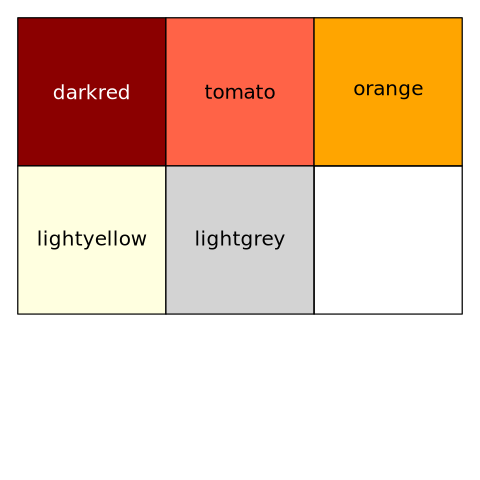

In [8]:
fig(4,4)
scales::show_col(p.value.pal)

# Fisher test - helper functions

In [9]:
fisher.xy <- function(x.vector, y.vector, universe, haldane = NULL, haldane.add = .5, alternative = 'greater'){

    library(dplyr)

    if(any(!x.vector %in% universe)){
        print('Some elements in X are not in universe')
    }
    
    if(any(!y.vector %in% universe)){
        print('Some elements in Y are not in universe')
    }
    
    in.x <- universe %in% x.vector %>% as.character() %>% factor(levels = c('TRUE', 'FALSE'))
    in.y <- universe %in% y.vector %>% as.character() %>% factor(levels = c('TRUE', 'FALSE'))
    cont.table <- table(in.x, in.y)

    in.both.string <- paste(intersect(x = x.vector, y = y.vector), collapse =',')
    

    # print(cont.table)
    
    if (is.null(haldane) & any(cont.table == 0)){
        print('Adding Haldane correction')
        haldane <- T
    }
    if (haldane){
        cont.table <- cont.table + haldane.add
    }

    ft <- fisher.test(cont.table, alternative = alternative)
    
    unlist(ft) %>% head(-1) %>% as.data.frame %>% t() %>% as.data.frame %>% 
        mutate_at(c('p.value', 'conf.int1', 'conf.int2', 'estimate.odds ratio', 'null.value.odds ratio'), as.numeric) %>% 
        mutate(
            NOTin.X.NOTin.Y = cont.table['FALSE','FALSE'],
            NOTin.X.in.Y = cont.table['FALSE','TRUE'],
            in.X.NOTin.Y = cont.table['TRUE','FALSE'],
            in.X.in.Y = cont.table['TRUE','TRUE'],
            which.in.X.in.Y = in.both.string
        ) -> ft.df

    return(ft.df)
    
}

In [10]:
fisher.xy.multiple <- function(x.lists, y.lists, n.cores = parallel::detectCores(), ...){

    if (n.cores>1){
        
        require(parallel)

        print(glue('Running in parallel ({n.cores} cores)...'))
        all.list <- list()
    
        for(ix in 1:length(x.lists)){
            for(iy in 1:length(y.lists)){
                all.list[[length(all.list)+1]] <- list(
                    x.vector = x.lists[[ix]],
                    x.name = names(x.lists)[ix],
                    y.vector = y.lists[[iy]],
                    y.name = names(y.lists)[iy]
                )
            }
        }
              
        print(glue('Number of tests: {length(all.list)}'))
        
        res <- mclapply(all.list, mc.cores = ncores, function(pars) {
        # res <- lapply(all.list, function(pars) {
            fisher.xy(x.vector = pars$x.vector, y.vector = pars$y.vector, ...) %>% 
            mutate(list.x = pars$x.name, list.y = pars$y.name)
        })    
        
    
    } else {
    
        lapply(1:length(x.lists), function(ix){
            lapply(1:length(y.lists), function(iy){
                fisher.xy(x.vector = x.lists[[ix]], y.vector = y.lists[[iy]], ...) %>% 
                mutate(list.x = names(x.lists)[ix], list.y = names(y.lists)[iy])
            })
        }) %>% unlist(recursive = F) -> res        
    }

    res <- do.call(what = 'rbind', res)
    
    return(res)

}

In [11]:
plot_sizes <- function(nwk.df){

    require(ggplot2)
    
    nwk.df$p.break <- cut(nwk.df$p, breaks = c(0, 0.0001, 0.001, 0.01, 0.05), include.lowest = T)
    nwk.df %>% group_by(source) %>% summarise(n = length(target)) %>% ungroup() %>% arrange(n) %>% select(source) %>%unlist %>% unique() -> sorted.sources
    
    ggplot(nwk.df, aes(y = factor(source, levels = sorted.sources), fill = p.break)) + 
        geom_bar(position = 'stack', color = 'black', linewidth = 0.5) + 
        scale_fill_viridis_d(na.value = 'darkgrey', direction = -1) + 
        labs(x = 'Number of targets', y = 'Regulon (TF)', fill = 'Significance') +
        theme_minimal() + labs_pubr() -> p1


    nwk.df %>% subset(!is.na(p)) %>% group_by(source) %>% summarise(n = length(target)) %>% ungroup() -> sizes.df
    p2 <- ggplot(sizes.df, aes(x=n)) +
        geom_histogram(fill = 'gold3', color = 'black') + 
        theme_light() + 
        scale_y_continuous(expand = expansion(mult = c(0,0.05)))+ 
        labs(x = 'Number of targets', y = 'Number of regulons') +
        theme_minimal() + labs_pubr() 
    
    return(list(bars = p1, histogram = p2))
   
}

# plot_sizes(nwk.df)

In [12]:
rank.in.group <- function(df, rank.var, group.var=NULL, ascending=TRUE, ties.method = 'random', subset.max.rank = NULL, rank.name = 'rank'){

    df$idx <- 1:nrow(df)
    m <- if(ascending){1}else{-1}

    if (is.null(group.var)){
        df.groups <- list('group' = df)
    } else {
        
        groups <- apply(df[, group.var, drop=F], 1, paste, collapse = '-')
        df.groups <- split(df, groups)
    }
    
    lapply(df.groups, function(gdf){
        data.frame(
            rank = rank(gdf[,rank.var, drop=T]*m, ties.method = ties.method), 
            idx = gdf$idx
        )
    }) %>% do.call(what = 'rbind') -> ranks

    df[,rank.name] <- plyr::mapvalues(from = ranks$idx, to = ranks$rank, x = df$idx)
    df$idx <- NULL
    
    if (is.null(subset.max.rank)){
        return(df)   
    } else {
        return(subset(df, rank <= subset.max.rank))
    }
}

In [13]:
# remove non-significant 
only_significant <- function(d, mode = 'lines'){
    if (!mode %in% c('lines', 'points')){
        stop('Mode must be lines or points')
    }

    signs <- d$p.value <= 0.05

    if (mode == 'points'){
        return(d[signs,])
    } else {
        sign.tfs <- unique(d$list.x[signs])
        return(subset(d, list.x %in% sign.tfs))
    }
}

In [14]:
check_lists <- function(a,b){

    for (d in names(a)){
        message(d)
        osize <- length(a[[d]])
        fsize <- length(b[[d]])   
        print(glue('Original size: {osize}\t Filtered size: {fsize}\tChange: {round((fsize-osize)/osize*100, 2)}%'))
    }
}

# check_lists(disease.genelists, valid.gene_lists)

# Fisher test of GRNs in CellOracle

In [15]:
fig(5,17)

In [ ]:
all.tests <- list()

top.n <- Inf

# Define base directory for input data (e.g., CellOracle GRNs)
base_input_dir <- '/users/genomics/xoel/codebases/co_new/data/' 
# Define directory containing HVG files (e.g., current directory)
hvg_dir <- '.' 

# Define data directory using the base path
data.dir <- base_input_dir 

list.dirs(data.dir, recursive = F)
# Define the filename for storing Fisher's exact test results
ft.results.file <- glue('enrichments.top_networks.{top.n}_targets.csv')

[1] "/users/genomics/xoel/codebases/co_new/data//.ipynb_checkpoints"   
 [2] "/users/genomics/xoel/codebases/co_new/data//Downsampled"          
 [3] "/users/genomics/xoel/codebases/co_new/data//figures"              
 [4] "/users/genomics/xoel/codebases/co_new/data//Gliogenesis"          
 [5] "/users/genomics/xoel/codebases/co_new/data//GliogenesisExtended"  
 [6] "/users/genomics/xoel/codebases/co_new/data//NeuralPCW16"          
 [7] "/users/genomics/xoel/codebases/co_new/data//NeuralPCW20"          
 [8] "/users/genomics/xoel/codebases/co_new/data//NeuralPCW21"          
 [9] "/users/genomics/xoel/codebases/co_new/data//NeuralPCW24"          
[10] "/users/genomics/xoel/codebases/co_new/data//RGCmaturation"        
[11] "/users/genomics/xoel/codebases/co_new/data//RGCmaturationExtended"

In [17]:
overwrite <- F

In [ ]:
if(!file.exists(ft.results.file) | overwrite){
    
    for (dataset in datasets){
        
        print(paste(rep('#', length.out = 20), collapse = ''))
        print(dataset)
        print(paste(rep('#', length.out = 20), collapse = ''))
        
        print('Getting HVGs...')
        # Construct full path to HVG file using hvg_dir
        hvg.path <- glue('{hvg_dir}/hvg_{dataset}.txt') 
        gene.universe <- scan(hvg.path, '')
        print(length(gene.universe))
    
        print('Removing genes in gene lists not in gene universe...')
        valid.gene_lists <- disease.genelists %>% lapply(function(x){x[x%in%gene.universe]}) %>% setNames(names(disease.genelists))
        valid.gene_lists <- valid.gene_lists[sapply(valid.gene_lists, length) != 0]
    
        print('Listing network files...')
        
        nwk.dir <- glue('{data.dir}{dataset}/cluster_GRN/')
        nwk.files <- grep('raw', invert = F, fixed = T, list.files(nwk.dir), value = T)
        nwk.files <- paste0(nwk.dir, nwk.files)
        
        for (nwk.file in nwk.files){
        
            cell.type <- strsplit(basename(nwk.file), split = '.', fixed = T)[[1]][1]
            message(cell.type)
    
            # Read network data for the current file
            data.table::fread(nwk.file, data.table=F, nThread = 4)[,-1] %>% mutate(
                source.disease = source %in% disease.geneset,
                target.disease = target %in% disease.geneset
            ) -> nwk.df 
    
            print(dim(nwk.df))
            
            print('Removing NA edges...')
            nwk.df <- subset(nwk.df, !is.na(p))
            print(dim(nwk.df))

            print('Checking if all not-NA genes are in the universe.')
            if (!all(unique(nwk.df$target)%in%gene.universe)){
                print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                stop('Not all targets (with a pvalue) are in the gene universe')
            }
    
            print('Removing targets not in gene universe (should not change)...')
            nwk.df <- subset(nwk.df, target %in% gene.universe)
            print(dim(nwk.df))
           
            print('Removing non-significant edges...')
            nwk.df <- subset(nwk.df, p <=0.05)
            print(dim(nwk.df))

            print('Subsetting to top...')
            nwk.df <- nwk.df %>% group_by(source) %>% arrange(p) %>% slice_head(n = top.n) 
            print(dim(nwk.df))
    
            print('Getting targets per TF...')
            targets.lists <- with(nwk.df, {split(target, source)})
            print(dim(nwk.df))
    
            print('Running fisher tests...')
            fts <- fisher.xy.multiple(targets.lists, valid.gene_lists, universe = gene.universe, haldane = F)
    
            print('Saving results...')
            fts$cell.type <- cell.type
            fts$dataset <- dataset
            all.tests[[make.names(paste(dataset, cell.type))]] <- fts
        }
    
    }
    
    tests.df <- do.call(all.tests, what = 'rbind')
    data.table::fwrite(tests.df, ft.results.file)

}

# Process results

In [19]:
tests.df <- data.table::fread(ft.results.file, data.table=F, nThread = ncores)
tests.df <- subset(tests.df, list.y%in%disease.info$Disease)

table(tests.df$p.value < 0.05)


 FALSE   TRUE 
115374  15626 

## Correct p-values
3 levels of correction, from more general to more specific
- Per dataset
- Per dataset and disease
- Per dataset and disease and celltype

In [20]:
tests.df$q.value <- -log10(tests.df$p.value)
tests.df$sign.pvalue <- tests.df$p.value <= 0.05

# correct p-values 
tests.df <- tests.df %>% group_by(dataset) %>% 
    mutate(p.adj.dataset = p.adjust(p = p.value, method = 'fdr'),
           sign.adj.dataset = p.adj.dataset <= 0.05,
           q.adj.dataset = -log10(p.adj.dataset)) %>% ungroup()
tests.df <- tests.df %>% group_by(dataset, list.y) %>% 
    mutate(p.adj.dataset.disease = p.adjust(p = p.value, method = 'fdr'),
           sign.adj.dataset.disease = p.adj.dataset.disease <= 0.05,
           q.adj.dataset.disease = -log10(p.adj.dataset.disease)) %>% ungroup()
tests.df <- tests.df %>% group_by(dataset, list.y, cell.type) %>% 
    mutate(p.adj.dataset.disease.celltype = p.adjust(p = p.value, method = 'fdr'),
           sign.adj.dataset.disease.celltype = p.adj.dataset.disease.celltype <= 0.05,
           q.adj.dataset.disease.celltype = -log10(p.adj.dataset.disease.celltype)) %>% ungroup()


In [21]:
(tests.df %>% select(sign.adj.dataset, sign.adj.dataset.disease, sign.adj.dataset.disease.celltype, sign.pvalue)) %>%
    apply(MARGIN = 1, function(x){
        best <- min(c(1:5)[c(x, T)])
        p.value.symbols[best]
    }) %>% factor(levels = p.value.symbols, labels = p.value.tags) -> tests.df$sign.tag

In [22]:
tests.df %>% select(sign.adj.dataset, sign.adj.dataset.disease, sign.adj.dataset.disease.celltype, sign.pvalue ) %>% apply(MARGIN = 2, table)
table(tests.df$sign.tag)

,sign.adj.dataset,sign.adj.dataset.disease,sign.adj.dataset.disease.celltype,sign.pvalue
FALSE,130102,127113,126991,115374
TRUE,898,3887,4009,15626



                                              FDR <= 0.05 
                                                      898 
              FDR <= 0.05\n(p-value corrected by disease) 
                                                     3032 
FDR <= 0.05\n(p-value corrected by disease and cell type) 
                                                      197 
                                          p-value <= 0.05 
                                                    11499 
                                           p-value > 0.05 
                                                   115374 

In [38]:
tests.df %>% 
mutate(Log2OddsRatio = log2(`estimate.odds ratio`)) %>%
select(
    dataset,
    cell.type,
    list.x,
    list.y,
    which.in.X.in.Y,
    `estimate.odds ratio`,
    Log2OddsRatio,
    p.value,
    p.adj.dataset,
    p.adj.dataset.disease,
    p.adj.dataset.disease.celltype,
    in.X.in.Y,
    in.X.NOTin.Y,
    NOTin.X.in.Y,
    NOTin.X.NOTin.Y
) %>% rename(
    Dataset = dataset,
    `Cell type` = cell.type,
    TF = list.x,
    Disease = list.y,
    `Targets & disease-risk` = which.in.X.in.Y,
    `Odds ratio` = `estimate.odds ratio`,
    `p-value` = p.value,
    `p-value adjusted by dataset` = p.adj.dataset,
    `p-value adjusted by dataset and disease` = p.adj.dataset.disease,
    `p-value adjusted by dataset, disease and celltype` = p.adj.dataset.disease.celltype,
    `# targets & disease-risk` = in.X.in.Y,
    `# targets & NOT disease-risk` = in.X.NOTin.Y,
    `# NOT targets & disease-risk` = NOTin.X.in.Y,
    `# NOT targets & NOT disease-risk` = NOTin.X.NOTin.Y
) %>% arrange_all() -> sup.table



In [ ]:
# Define supplementary table filename
supp_table_filename <- 'supp_table.7.DiseaseEnrichment_in_CellOracle_GRNs.xlsx'

# Write supplementary table using the variable
openxlsx::write.xlsx(
    sup.table, supp_table_filename)

In [27]:

'p.value''conf.int1''conf.int2''estimate.odds ratio''null.value.odds ratio''alternative''method''NOTin.X.NOTin.Y''NOTin.X.in.Y''in.X.NOTin.Y''in.X.in.Y''which.in.X.in.Y''list.x''list.y''cell.type''dataset''q.value''sign.pvalue''p.adj.dataset''sign.adj.dataset''q.adj.dataset''p.adj.dataset.disease''sign.adj.dataset.disease''q.adj.dataset.disease''p.adj.dataset.disease.celltype''sign.adj.dataset.disease.celltype''q.adj.dataset.disease.celltype''sign.tag'

tests.df %>% select(
    
)

p.value,conf.int1,conf.int2,estimate.odds ratio,null.value.odds ratio,alternative,method,NOTin.X.NOTin.Y,NOTin.X.in.Y,in.X.NOTin.Y,⋯,p.adj.dataset,sign.adj.dataset,q.adj.dataset,p.adj.dataset.disease,sign.adj.dataset.disease,q.adj.dataset.disease,p.adj.dataset.disease.celltype,sign.adj.dataset.disease.celltype,q.adj.dataset.disease.celltype,sign.tag
<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<int>,<int>,<int>,⋯,<dbl>,<lgl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<lgl>,<dbl>,<fct>
0.032961742,1.10518221,Inf,2.5770712,1,greater,Fisher's Exact Test for Count Data,2695,27,271,⋯,0.3895752,FALSE,0.40940865,0.71390955,FALSE,0.14635681,0.58330726,FALSE,0.23410262,p-value <= 0.05
1.000000000,0.00000000,Inf,0.0000000,1,greater,Fisher's Exact Test for Count Data,2717,5,278,⋯,1.0000000,FALSE,0.00000000,1.00000000,FALSE,0.00000000,1.00000000,FALSE,0.00000000,p-value > 0.05
0.092437302,0.75933927,Inf,3.2864186,1,greater,Fisher's Exact Test for Count Data,2713,9,275,⋯,0.5453291,FALSE,0.26334133,1.00000000,FALSE,0.00000000,1.00000000,FALSE,0.00000000,p-value > 0.05
0.642945248,0.23675932,Inf,0.9170652,1,greater,Fisher's Exact Test for Count Data,2690,32,275,⋯,1.0000000,FALSE,0.00000000,0.85647230,FALSE,0.06728668,0.87407471,FALSE,0.05845145,p-value > 0.05
0.199988523,0.41870359,Inf,2.8090760,1,greater,Fisher's Exact Test for Count Data,2715,7,276,⋯,0.7036011,FALSE,0.15267350,0.76024843,FALSE,0.11904447,0.75171972,FALSE,0.12394405,p-value > 0.05
1.000000000,0.00000000,Inf,0.0000000,1,greater,Fisher's Exact Test for Count Data,2695,27,278,⋯,1.0000000,FALSE,0.00000000,1.00000000,FALSE,0.00000000,1.00000000,FALSE,0.00000000,p-value > 0.05
0.442327618,0.08391639,Inf,1.9612049,1,greater,Fisher's Exact Test for Count Data,2717,5,277,⋯,0.8877228,FALSE,0.05172264,1.00000000,FALSE,0.00000000,1.00000000,FALSE,0.00000000,p-value > 0.05
1.000000000,0.00000000,Inf,0.0000000,1,greater,Fisher's Exact Test for Count Data,2713,9,278,⋯,1.0000000,FALSE,0.00000000,1.00000000,FALSE,0.00000000,1.00000000,FALSE,0.00000000,p-value > 0.05
0.002277736,1.84416276,Inf,4.2120623,1,greater,Fisher's Exact Test for Count Data,2703,19,270,⋯,0.1194473,FALSE,0.92282384,0.14797238,FALSE,0.82981935,0.15384195,FALSE,0.81292524,p-value <= 0.05


### Stats of significant results

In [23]:
sign.stats <- rbind(
    tests.df %>% group_by(dataset, list.y, cell.type) %>% summarise(
    n.unique.tfs = length(unique(list.x)),
    n.significant.tfs = length(unique(list.x[!sign.tag%in% tail(p.value.tags, n = 2)]))),
    tests.df %>% group_by(dataset, list.y) %>% summarise(
    n.unique.tfs = length(unique(list.x)),
    n.significant.tfs = length(unique(list.x[!sign.tag %in% tail(p.value.tags, n = 2)]))) %>% mutate(cell.type = 'All')%>% select(dataset,list.y,cell.type, everything()))

`summarise()` has grouped output by 'dataset', 'list.y'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'dataset'. You can override using the
`.groups` argument.


In [24]:
# the data point we are looking for is:
# how many TFs are enriched per disease?

In [25]:
cbind(
    Mean = sign.stats%>% subset((cell.type == 'All')&(list.y != 'All')) %>% with(expr = {
        split(n.significant.tfs, dataset) %>% lapply(mean)}),
    Median = sign.stats%>% subset((cell.type == 'All')&(list.y != 'All')) %>% with(expr = {
        split(n.significant.tfs, dataset) %>% lapply(median)}),
    `Standard deviation` = sign.stats%>% subset((cell.type == 'All')&(list.y != 'All')) %>% with(expr = {
        split(n.significant.tfs, dataset) %>% lapply(sd)})
) %>% as.data.frame -> sign.stats.summary
sign.stats.summary

,Mean,Median,Standard deviation
,<named list>,<named list>,<named list>
Gliogenesis,4.166667,0,14.49938
NeuralPCW20,7.875,0,22.05982
NeuralPCW21,4.875,0.5,10.88003
NeuralPCW24,5.25,0,15.34034


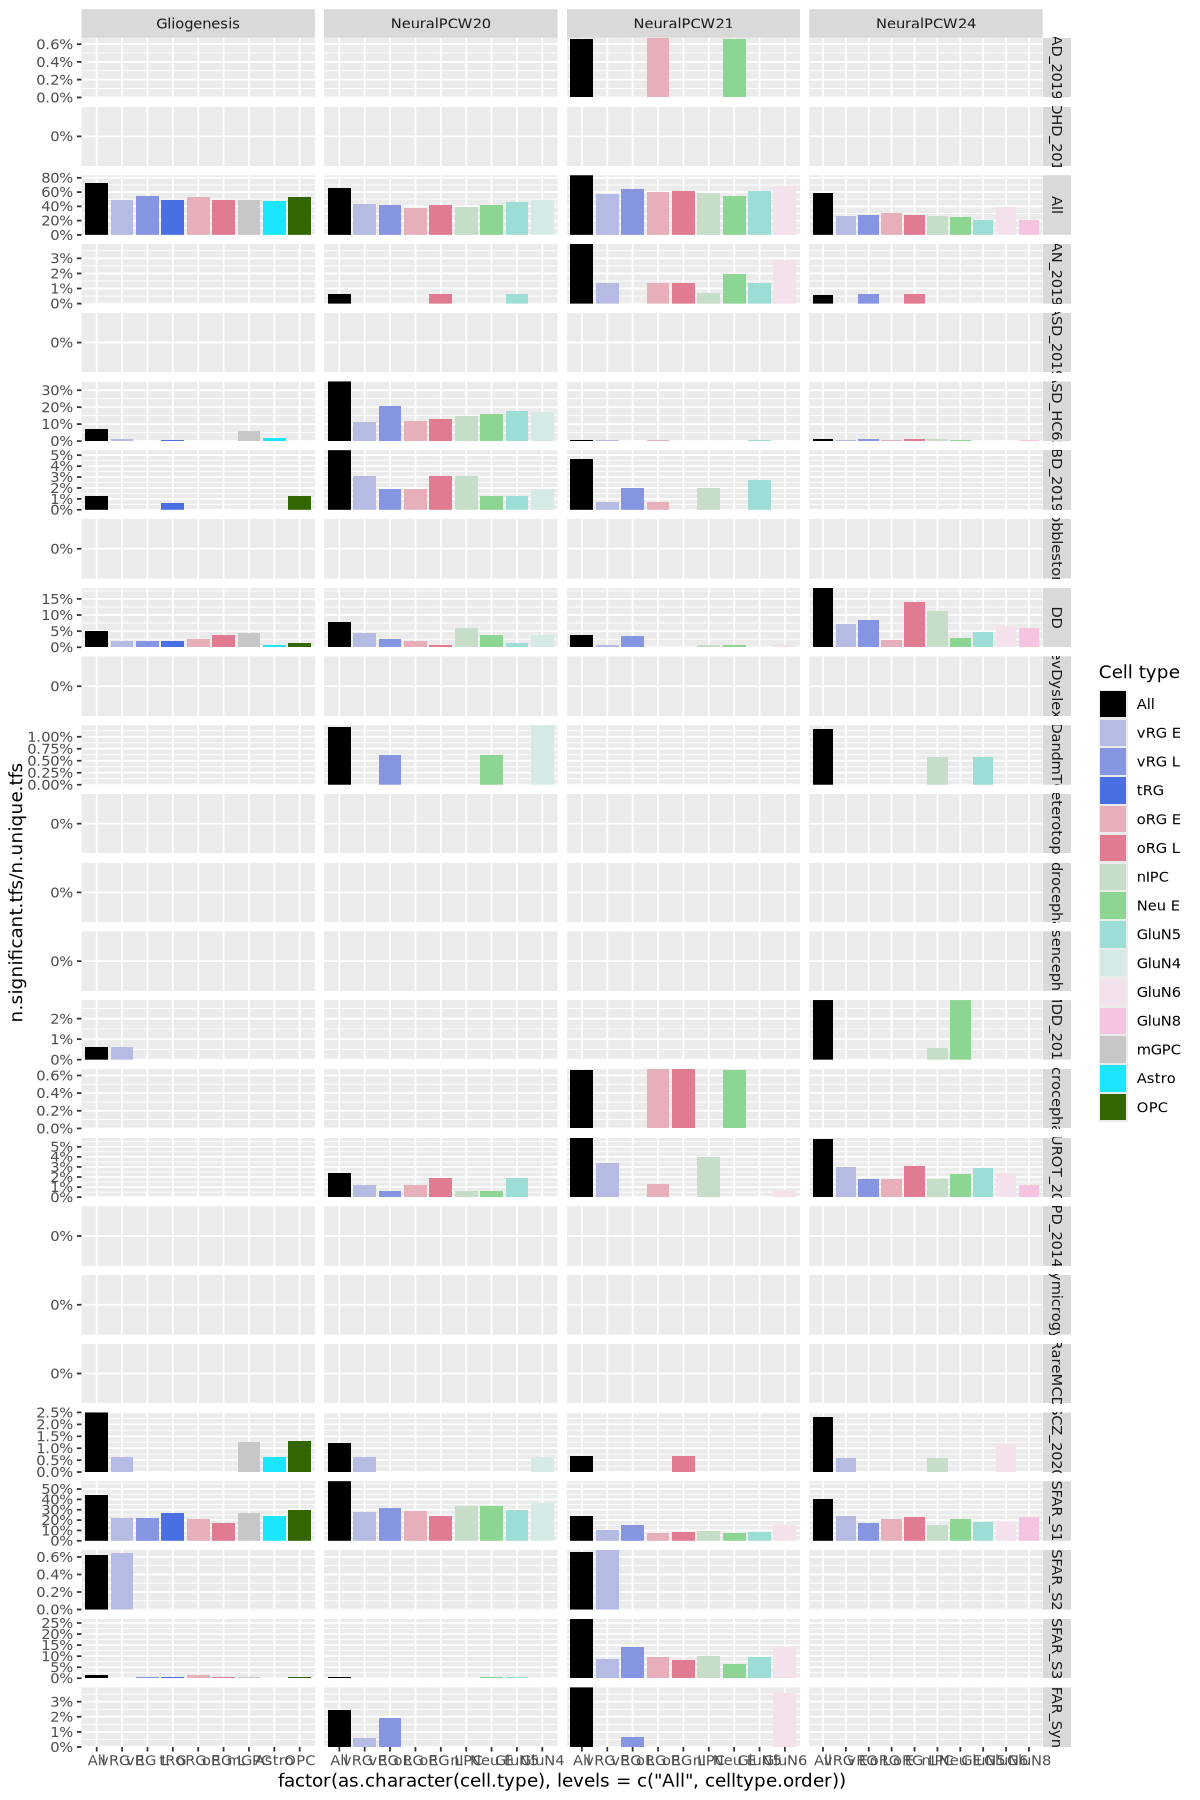

In [26]:
fig(10,15)
ggplot(sign.stats, aes(x = factor(as.character(cell.type), levels=c('All', celltype.order)),
                       fill = factor(as.character(cell.type), levels=c('All', celltype.order)),
                       y = n.significant.tfs/n.unique.tfs)) +
geom_bar(stat = 'identity') + 
facet_grid(cols = vars(dataset), rows = vars(list.y), scales = 'free') + 
scale_fill_manual('Cell type', values = c(celltype.colors, 'All' = 'black')) + 
scale_y_continuous(labels = scales::label_percent(), limits = c(0,NA), expand = expansion(mult = c(0,0)))

## Factors

In [26]:
# factors
tests.df <- tests.df %>% mutate(
    cell.type = factor(cell.type, levels = celltype.order) %>% droplevels,
    list.y = factor(list.y, levels = disease.info$Disease) %>% droplevels,
    dis.label = factor(plyr::mapvalues(x = list.y, from = disease.info$Disease, 
                                       to = disease.info$DiseaseLabel), levels = unique(disease.info$DiseaseLabel)) %>% droplevels,
    dis.group = factor(plyr::mapvalues(x = list.y, from = disease.info$Disease, 
                                       to = disease.info$DiseaseGroup), levels = unique(disease.info$DiseaseGroup)) %>% droplevels
)


tests.df$OR <- ifelse(tests.df$`estimate.odds ratio` == Inf,
                      max(tests.df$`estimate.odds ratio`[is.finite(tests.df$`estimate.odds ratio`)]), 
                      tests.df$`estimate.odds ratio`)
# tests.df$mark <- (tests.df$OR >=2) & (tests.df$p.value <= 0.05)
tests.df$mark <- (tests.df$p.value <= 0.05)
tests.df$label.dis.tf <- paste(substr(tests.df$list.y, start = 1, stop = 3), tests.df$list.x, sep = '\n')
tests.df$label.ct.tf <- paste(tests.df$cell.type, tests.df$list.x, sep = '\n')
tests.df$label.complete <- paste(tests.df$dataset, tests.df$list.y, tests.df$cell.type, tests.df$list.x, sep = '\n')
tests.df$logOR <- ifelse(tests.df$OR == 0, NA, log2(tests.df$OR))
# tests.df$logOR <- ifelse(tests.df$logOR == -Inf, -max(abs(tests.df$logOR[is.finite(tests.df$logOR)])), tests.df$logOR)

## Per dataset

In [ ]:
# pdata.list: A list containing processed enrichment data, split by dataset
pdata.list <- split(tests.df, tests.df$dataset) %>% 
    lapply(function(pdata){ # pdata: Subset of enrichment data for a single dataset

        # for each tf and disease, find the ct with the best p-value
        pdata <- pdata %>%
        group_by(dataset, list.x, list.y) %>% 
        mutate(max.logp = max(q.value), 
               max.ct = cell.type[rank(p.value, ties.method = 'random', na.last = T) == 1]) %>%
        ungroup %>% arrange(dataset, list.x, list.y)

        # rank best cell types-tfs for each disease
        unique(pdata[,c('dataset', 'list.x', 'list.y', 'max.ct', 'max.logp')]) %>% 
        rank.in.group(subset.max.rank = NULL,
                      ascending = F,
                      rank.var = 'max.logp', 
                      group.var = c('dataset', 'list.y')) %>% mutate(max.logp=NULL, max.rank = rank, rank = NULL) %>%
        # join with the rest of the data
        merge(y = pdata, by = c('dataset', 'list.x', 'list.y', 'max.ct')) %>% 
        # add labels
        mutate(max.label = ifelse((max.rank <= 5) & (cell.type == max.ct) & (p.value <= 0.05), list.x, NA)) %>%
        # drop unnecessary levels
        mutate_if(is.factor, droplevels)
    })

# Plots

In [28]:
stylize <- function(p, rotate_x_90 = F, rotate_x_45 = T, remove_grid = T, legend.position = NULL){

    require(ggpubr)
    
    p <- p + theme_light() + 
        labs_pubr()
    if (rotate_x_90){
        p <- p + theme(axis.text.x = element_text(angle = 90, hjust=1, vjust=0.5))
    }

    if(rotate_x_45){
        p <- p + theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))
    }
    if (remove_grid){
        p <- p + theme(panel.grid = element_blank())
    }
    if(!is.null(legend.position)){
        p <- p + theme(legend.position = legend.position)
    }

    p <- p + theme(
        strip.placement = 'outside',
        strip.text = element_text(color = 'black'),
        strip.background = element_rect(fill='#DDDDDD', color = 'transparent'),
        panel.border = element_blank(),
        )

    return(p)
}


In [ ]:
# Define base directory for plots
base_plot_dir <- './plots/'

# Create output directories using the variable
outDir_list <- lapply(names(pdata.list), function(x){glue('{base_plot_dir}{x}/')}) %>% setNames(names(pdata.list))
lapply(outDir_list, dir.create, recursive = T, showWarnings = F)

$Gliogenesis
[1] FALSE

$NeuralPCW20
[1] FALSE

$NeuralPCW21
[1] FALSE

$NeuralPCW24
[1] FALSE

### Lines plot

In [30]:
fig(15,15)
do.lines.plot <- function(pdata){
    
    p <- ggplot(only_significant(pdata),
       aes(y = q.value,
           x = droplevels(cell.type), 
           group = paste(list.x, list.y, dataset),
           
           linewidth = max.rank <=5,
           alpha = max.rank <=5,
           color = factor(ifelse(max.rank <=5, as.character(max.ct), NA), 
                          levels = levels(cell.type)))) +

    scale_color_manual('Cell type', values= celltype.colors) + 
    scale_alpha_manual('Top 5', values= c('TRUE' = 1, 'FALSE' = 0.1)) + 
    scale_linewidth_manual('Top 5', values= c('TRUE' = 1, 'FALSE' = 0.2)) + 

    geom_line() +
    geom_hline(yintercept = -log10(0.05), color = 'red') +

    facet_wrap2(~list.y, axes = "all", remove_labels = 'none', scales = 'free_y', ncol = 4)

p <- stylize(p)
}


lapply(names(pdata.list), function(s){
    
    print(s)
    pdata <- pdata.list[[s]]
    p <- do.lines.plot(pdata) +
        geom_text_repel(data = subset(pdata, !is.na(max.label)), mapping = aes(label = max.label), max.overlaps = Inf, min.segment.length = 0)
    
    pdf(glue('{outDir_list[[s]]}Lines.v6.pdf'), width = 15, height = 15)
    plot(p)
    dev.off()
})

# p

[1] "Gliogenesis"
[1] "NeuralPCW20"
[1] "NeuralPCW21"
[1] "NeuralPCW24"


[[1]]
pdf 
  2 

[[2]]
pdf 
  2 

[[3]]
pdf 
  2 

[[4]]
pdf 
  2

### Violin plot

In [31]:
fig(15,15)
do.violin.plot <- function(pdata){
            
    p <- ggplot(pdata,
           aes(y = q.value,
               x = cell.type, 
               fill = cell.type,
              )) +
    
        scale_fill_manual('Cell type', values= celltype.colors) + 
    
        geom_line(mapping = aes(group = paste(list.x, list.y, dataset)), color='black', linewidth = 0.2, alpha = 0.1) +
        geom_hline(yintercept = -log10(0.05), color = 'red') +
        geom_violin(alpha=0.8) +
    
        facet_wrap2(~list.y, axes = "all", remove_labels = 'none', scales = 'free_y', ncol = 4)
    
    p <- stylize(p, remove_grid = F)

}



lapply(names(pdata.list), function(s){
    
    print(s)
    pdata <- pdata.list[[s]]
    p <- do.violin.plot(pdata)
    
    pdf(glue('{outDir_list[[s]]}Violin.v6.pdf'), width = 15, height = 15)
    plot(p)
    dev.off()
})


[1] "Gliogenesis"
[1] "NeuralPCW20"
[1] "NeuralPCW21"
[1] "NeuralPCW24"


[[1]]
pdf 
  2 

[[2]]
pdf 
  2 

[[3]]
pdf 
  2 

[[4]]
pdf 
  2

### Heatmap plot

In [32]:
cluster_genes <- function(d, formula = 'list.x ~ list.y + cell.type', fill = 0, n = 5){
    m <- reshape2::dcast(d, formula = formula, fill = fill, value.var = 'q.value')
    k <- amap::Kmeans(x = m[,-1], centers = n, iter.max=10e5)

    d <- data.frame(Gene = m[,1], cluster = k$cluster)
    split(d$Gene, d$cluster) %>% lapply(function(y){
        if (length(y) < 2){
            return(y)
        }
        subm <- subset(m, list.x%in%y)
        subm$list.x[hclust(dist(subm[,-1]), method = 'ward.D2')$order]
        }) %>% unlist -> gene.levels
    d$list.x <- factor(d$Gene, levels = gene.levels)
    return(d %>% arrange(cluster, Gene))
}

In [33]:
fig(30,20)

do.heatmap.plot <- function(pdata){

    k <-cluster_genes(pdata, formula = 'list.x ~ list.y + cell.type')

    pdata <- merge(pdata, k, by = 'list.x', all=T) %>% mutate(list.x = factor(list.x, levels(k$list.x)))
    
    p1 <- ggplot(only_significant(pdata, mode = 'lines'),
           aes(y = list.x,
               x = cell.type, 
               fill = q.value,
              )) +
    
        scale_fill_viridis_c(option='turbo') +
        geom_tile() +
        
        facet_nested(cols = vars(list.y))
        
    p1 <- stylize(p1)
    
    
    p2 <- ggplot(only_significant(pdata, mode = 'points'),
           aes(y = list.x,
               x = cell.type, 
               fill = q.value,
              )) +
    
        scale_fill_viridis_c(option='turbo') +
        geom_tile() +
        
        facet_nested(cols = vars(list.y))
        
    p2 <- stylize(p2)
    
    
    p3 <- ggplot(only_significant(pdata, mode = 'lines'),
           aes(y = list.x,
               x = cell.type, 
               fill = sign.tag,
              )) +
    
        scale_fill_manual(values = p.value.pal) +
        geom_tile(color='darkgrey', linewidth = .1) +
        
        facet_nested(cols = vars(list.y))
        
    p3 <- stylize(p3, remove_grid = T)

    return(list(
        'Only sign TFs' = p1,
        'Only sign TFs - p-value category' = p3,
        'Only sign cells' = p2))
}




lapply(names(pdata.list), function(s){
    
    print(s)
    pdata <- pdata.list[[s]]
    plist <- do.heatmap.plot(pdata)

    pdf(glue('{outDir_list[[s]]}Heatmaps.v6.pdf'), width = 30, height = 20)
    lapply(names(plist), function(ss){
        plot(plist[[ss]] + ggtitle(ss))
    })
    dev.off()
})


[1] "Gliogenesis"
[1] "NeuralPCW20"
[1] "NeuralPCW21"
[1] "NeuralPCW24"


[[1]]
pdf 
  2 

[[2]]
pdf 
  2 

[[3]]
pdf 
  2 

[[4]]
pdf 
  2

### Barcode plots

In [34]:
do.barcode.plot <- function(pdata, nrow = NULL, ncol = 1, nrank = 15, qval.var, pval.ranking.var){

    split(pdata, droplevels(pdata$list.y)) %>%
    lapply(function(d){

        dis <- unique(d$list.y)
        d <- rank.in.group(d, rank.var = pval.ranking.var, group.var = NULL, 
                           ascending = T, rank.name = 'rank.global') %>%
            subset(rank.global <= nrank)

        d <- d %>% mutate(x_axis = factor(as.character(rank.global), levels = as.character(sort(rank.global)))) %>% 
            arrange(x_axis) %>% 
            mutate(x_axis = factor(label.ct.tf, unique(label.ct.tf)))
        
        p <- ggplot(d, aes_string(x = 'x_axis', 
                                  y = qval.var, 
                                  fill = 'factor(cell.type, levels = celltype.order)') 
                   ) + 
                geom_bar(stat = 'identity') + 
                geom_hline(yintercept = -log10(0.05), color = 'red', linewidth = 1, alpha=0.4) +
                geom_text(aes_string(y=paste0(qval.var, '*1.1'), label='in.X.in.Y', size=NULL), angle=45, hjust=0, vjust=0) +
                scale_fill_manual('Cell type', values= celltype.colors) + 
                scale_x_discrete('TF and cell type', labels = function(x){sapply(x, function(y){strsplit(y, split = '\n')[[1]][2]})}, expand = expansion(add=c(0,0), mult = c(0,0.1))) +
                scale_y_continuous('Enrichment', expand = expansion(add=c(0,0), mult = c(0,0.4))) + 
                ggtitle(dis) + 
                labs(x = NULL, y=NULL)
        
        p <- stylize(p, rotate_x_90 = T, legend.position = 'none')

        return(p)
    }) %>% cowplot::plot_grid(plotlist = ., ncol = ncol, nrow = nrow, align = 'hv', axis = 'tblr') -> p

    return(p)
}

In [ ]:
fig(15,6)

pval.var <- 'p.adj.dataset.disease.celltype'
qval.var <- 'q.adj.dataset.disease.celltype'

# stacked: List to store the Top 15 barcode plots for significant diseases per dataset
stacked <- list()

lapply(names(pdata.list), function(s){
    
    print(s)
    pdata <- pdata.list[[s]]

    n.dis <- length(unique(pdata$list.y))
    pdf(glue('{outDir_list[[s]]}Barcode.Top15.v6.pdf'), width = 16, height = 15)
    plot(do.barcode.plot(pdata, ncol = 4, nrank = 15, pval.ranking.var = pval.var, qval.var = qval.var))
    dev.off()
    # stop()
    pdf(glue('{outDir_list[[s]]}Barcode.Top50.v6.pdf'), width = 30, height = 20)
    plot(do.barcode.plot(pdata, ncol = 3, nrank = 50, pval.ranking.var = pval.var, qval.var = qval.var))
    dev.off()

    
    
    # remove diseases with no significant enrichment
    pdata$is.signif <- pdata[,pval.var] <= 0.05 
    sign.dis <- pdata %>% group_by(list.y) %>% summarise(n.enr=sum(is.signif)) %>% subset(n.enr>0) %>% select(list.y) %>% unlist()
    pdata <- subset(pdata, list.y %in% sign.dis)
    n.sign.dis <- length(unique(pdata$list.y))
    h1 <- 15/ceiling(n.dis/4)*n.sign.dis/4
    h2 <- 20/ceiling(n.dis/3)*n.sign.dis/3

    p <- do.barcode.plot(pdata, ncol = 4, nrank = 15, pval.ranking.var = pval.var, qval.var = qval.var)
    stacked[[s]] <- p 
    print(h1)
    pdf(glue('{outDir_list[[s]]}Barcode.OnlySignificantDiseases.Top15.v6.pdf'), width = 16, height = h1)
    plot(p)
    dev.off()

    pdf(glue('{outDir_list[[s]]}Barcode.OnlySignificantDiseases.Top50.v6.pdf'), width = 30, height = h2)
    plot(do.barcode.plot(pdata, ncol = 3, nrank = 50, pval.ranking.var = pval.var, qval.var = qval.var))
    dev.off()

    return(p)

}) -> stacked

[1] "Gliogenesis"
[1] 4.285714
[1] "NeuralPCW20"
[1] 5.357143
[1] "NeuralPCW21"
[1] 5.892857
[1] "NeuralPCW24"
[1] 4.821429


In [ ]:
titles <- lapply(names(pdata.list), function(s){
    require(cowplot)
    ggdraw() + draw_label(s, fontface = 'bold', x = 0, hjust = 0) + theme(plot.margin = margin(0, 0, 0, 7))})
plist <- list(
    titles[[1]], stacked[[1]],
    titles[[2]], stacked[[2]],
    titles[[3]], stacked[[3]],
    titles[[4]], stacked[[4]]
)

rel.h <- c(.5, 4, 
           .5, 6, 
           .5, 6, 
           .5, 6)
h <- sum(rel.h)

fig(16, h)
stacked.p <- cowplot::plot_grid(
    plotlist = plist,
    ncol=1, rel_heights = rel.h, 
    align ='vh', axis = 'tblr')

# Define output filename for combined barcode plot
combined_barcode_filename <- 'Barcode.OnlySignificantDiseases.Top15.v6.pdf'

# Save combined plot using base_plot_dir and defined filename
pdf(glue('{base_plot_dir}{combined_barcode_filename}'), width = 16, height = h)
plot(stacked.p)
dev.off()


pdf 
  2

### Manhattan plot

In [36]:
manhattan.plot <- function(man.data, pval.var, y.var=NULL, ntop.genes=15,
                           only_significant_diseases = T, pval.threshold = 0.05){
    if (is.null(y.var)){
        y.var <- pval.var %>% gsub(pattern = 'p.', replacement = 'q.', fixed=T)
    }
    man.data <- rank.in.group(man.data,
                              rank.name = 'rank.Dis',
                              subset.max.rank = NULL,
                              rank.var = pval.var, 
                              group.var = c('list.y')) %>% arrange(list.y, rank.Dis)
    
    # now for each disease, find the N-th unique gene sorted by best pvalue 
    split(man.data, man.data$list.y) %>%
    lapply(function(d){
        # print(dim(d))
        sorted.genes <- d %>% arrange_at(pval.var) %>% 
                        select(list.x) %>% unlist() %>% unique()
        top.genes <- sorted.genes[1:ntop.genes]
        d <- subset(d, list.x %in% top.genes)
        # print(nrow(d))
        return(d)}) %>% 
    do.call(what = 'rbind') -> man.data
    
    # remove diseases with no significant enrichment
    if (only_significant_diseases){
        man.data$is.signif <- man.data[,pval.var] <= pval.threshold 
        sign.dis <- man.data %>% group_by(list.y) %>% summarise(n.enr=sum(is.signif)) %>% subset(n.enr>0) %>% select(list.y) %>% unlist()
        man.data <- subset(man.data, list.y %in% sign.dis)
    }

    ggplot(man.data, aes_string(
        shape = 'dataset',
        x = 'list.x',
        y = y.var, 
        size = 'sign.tag',
        color = 'cell.type')) + 
    geom_jitter(height = 0, width=0.1, alpha=0.75) + 
    # geom_point(height = 0, width=0.1, alpha=0.75) + 
    geom_hline(yintercept = -log10(0.05), color = 'black') +
    scale_size_manual(values = p.value.sizes) + 
    scale_color_manual(values = celltype.colors) +
    scale_shape_manual(values = dataset.shapes) +
    facet_wrap(~list.y, scales = 'free') -> p.manhattan
    
    return(
        stylize(p.manhattan, rotate_x_90 = T, rotate_x_45 = F, remove_grid = F)
    )
}


In [37]:
fig(15,15)

pval.var <- 'p.adj.dataset.disease.celltype'

lapply(names(pdata.list), function(s){
    
    print(s)
    pdata <- pdata.list[[s]]

    pdf(glue('{outDir_list[[s]]}Manhattan.Top15.v6.pdf'), width = 16, height = 15)
    plot(manhattan.plot(pdata, pval.var = pval.var, ntop.genes = 15) + ggtitle(glue('Enrichment results in {s}')))
    dev.off()

})


[1] "Gliogenesis"


Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


[1] "NeuralPCW20"
[1] "NeuralPCW21"
[1] "NeuralPCW24"


[[1]]
pdf 
  2 

[[2]]
pdf 
  2 

[[3]]
pdf 
  2 

[[4]]
pdf 
  2

In [ ]:
fig(20,15)

# Define output filename for combined Manhattan plot
combined_manhattan_filename <- 'Manhattan.Selection_and_overview.Top15.v6.pdf'

# Save combined Manhattan plots using base_plot_dir and defined filename
pdf(glue('{base_plot_dir}{combined_manhattan_filename}'), width = 16, height = 15)
manhattan.plot(man.data = subset(tests.df, dataset %in% c('Gliogenesis', 'NeuralPCW20')),
               pval.var = pval.var, ntop.genes = 15) + ggtitle(glue('Enrichment results in RGC maturation, Neurogenesis (PCW20) and Gliogenesis)'))
manhattan.plot(man.data = tests.df,
               pval.var = pval.var, ntop.genes = 15) + ggtitle(glue('Enrichment results in all trajectories (datasets)'))
dev.off()

pdf 
  2

### Rank lines

In [39]:
do.rankline.plot <- function(df, qval.var, axis.labels = F, title=T, axis.to.zero = T, vert.line = T, legend.position = 'none'){

    df <- df %>% arrange(rank) %>% as.data.frame
    p <- ggplot(df, aes_string(x=qval.var, y = 'rank', size = 'OR', fill = 'sign.tag')) +
        scale_fill_manual('Significant enrichment', values=p.value.pal)
    
    # offset <- max(df[,qval.var])/6
    offset <- 1
    tit <- paste(unique(df$cell.type), unique(df$list.y), sep = ' vs ')
    message(tit)

    # if (tit == 'oRG E vs SFAR_S1'){
    #     print(df)
    # }
    
    if (vert.line){
        p <- p + geom_vline(xintercept = -log10(0.05), color = 'orange')
    }
    
    p <- p +
        geom_segment(aes_string(x = 0, xend = qval.var, y='rank', yend='rank'), linewidth = 1, color = 'grey') +
        geom_point(shape=21) + 
        geom_text(aes_string(label = 'in.X.in.Y', x = paste0(qval.var,'+offset'), size=NULL), hjust=0) +

            scale_y_reverse(breaks = df$rank, labels = df$list.x) + 
        scale_x_continuous(
            limits = if (axis.to.zero){c(0,NA)}else{NULL},
            expand = expansion(mult = c(0,0), add = c(0,offset))
        )

    if (axis.labels){
        p <- p + labs(x='Enrichment\n(-log10 p-value)', y = 'Regulon TF')
    } else {
        p <- p + labs(x=NULL, y = NULL)
    }

    p <- stylize(p, legend.position = legend.position) + theme(panel.grid.major.x =  element_blank())

    if (title){
        p <- p + ggtitle(tit)
    }


    return(p)
}

In [ ]:
fig(25,5)

rng <- c(1,4)
pval.var <- 'p.adj.dataset.disease.celltype'
qval.var <- 'q.adj.dataset.disease.celltype'

top.enrich <- rank.in.group(tests.df,
                            subset.max.rank = 15,
                            rank.var = 'p.adj.dataset', 
                            group.var = c('dataset', 'cell.type', 'list.y')) %>% arrange(dataset, cell.type, list.y, rank)
lapply(
    X = split(top.enrich, top.enrich$dataset), 
    FUN = function(ds){
        
        data.name <- unique(ds$dataset)
        print(data.name)
        # remove diseases with no significant enrichment
        ds$is.signif <- ds[,pval.var] <= 0.05 
        sign.dis <- ds %>% group_by(list.y) %>% summarise(n.enr=sum(is.signif)) %>% subset(n.enr>0) %>% select(list.y) %>% unlist()
        ds <- subset(ds, list.y %in% sign.dis)
        
        limits <- c(min(ds$OR), max(ds$OR))
        size_scale <- scale_size_continuous(limits = limits, range = rng, guide = guide_none())
        x_scale <- scale_x_continuous(limits = c(0, max(ds[,qval.var]+1)), expand = expansion(add = c(0,2)))
        
        lapply(
            split(ds, droplevels(ds$list.y)),
            function(x){
                p.list <- lapply(split(x, droplevels(x$cell.type)), 
                                 do.rankline.plot, qval.var = qval.var) %>% lapply(function(x){x+size_scale+x_scale})
                p <- cowplot::plot_grid(plotlist = p.list, nrow = 1) 
                
                return(p)
            }) %>% cowplot::plot_grid(plotlist = ., ncol = 1) -> p
    
        cairo_pdf(glue('{outDir_list[[data.name]]}Ranklines.v6.pdf'), width = 20, height=length(sign.dis)*21/8, onefile = T)
        plot(p)
        dev.off()
        return(p)
}) -> p


[1] "Gliogenesis"


vRG E vs All

vRG L vs All

tRG vs All

oRG E vs All

oRG L vs All

mGPC vs All

Astro vs All

OPC vs All

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `lin

[1] "NeuralPCW20"


vRG E vs All

vRG L vs All

oRG E vs All

oRG L vs All

nIPC vs All

Neu E vs All

GluN5 vs All

GluN4 vs All

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
vRG E vs FCDandmTOR

vRG L vs FCDandmTOR

oRG E vs FCDandmTOR

oRG L vs FCDandmTOR

nIPC vs FCDan

[1] "NeuralPCW21"


vRG E vs All

vRG L vs All

oRG E vs All

oRG L vs All

nIPC vs All

Neu E vs All

GluN5 vs All

GluN6 vs All

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
vRG E vs Microcephaly

vRG L vs Microcephaly

oRG E vs Microcephaly

oRG L vs Microcephaly

nIPC 

[1] "NeuralPCW24"


vRG E vs All

vRG L vs All

oRG E vs All

oRG L vs All

nIPC vs All

Neu E vs All

GluN5 vs All

GluN6 vs All

GluN8 vs All

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the 